In [ ]:
import os
import numpy as np
import librosa
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from google.colab import drive

In [ ]:
# 스펙트로그램 생성 함수
def extract_spectrogram_segment(y, sr, start, duration=10, n_mels=128):
    """
    오디오 신호에서 시작 시간부터 일정 기간의 스펙트로그램을 생성하고 리사이즈.
    """
    y_segment = y[int(start * sr):int((start + duration) * sr)]  # 특정 구간의 샘플 추출
    if len(y_segment) < duration * sr:  # 10초보다 짧은 구간 제외
        return None  # 작은 구간은 None 반환

    # 스펙트로그램 생성
    spectrogram = librosa.feature.melspectrogram(y=y_segment, sr=sr, n_mels=n_mels)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

    # 스펙트로그램을 128x128 크기로 리사이즈 (OpenCV 활용)
    spectrogram_resized = cv2.resize(spectrogram_db, (128, 128), interpolation=cv2.INTER_CUBIC)
    return spectrogram_resized

# 데이터 로드 함수
def load_data_segments(data_path, labels, segment_duration=10):
    """
    오디오 파일을 10초 단위로 나누어 스펙트로그램을 생성하고 학습 데이터를 생성.
    """
    spectrograms = []
    genre_labels = []
    for label in labels:
        genre_folder = os.path.join(data_path, label)
        for file in os.listdir(genre_folder):
            if file.endswith('.wav'):  # .wav 파일만 처리
                file_path = os.path.join(genre_folder, file)
                try:
                    y, sr = librosa.load(file_path, sr=22050)  # 오디오 파일 로드 (샘플링 레이트: 22050)
                    total_duration = librosa.get_duration(y=y, sr=sr)
                    # 10초 단위로 데이터를 나눠 스펙트로그램 생성
                    for start in range(0, int(total_duration), segment_duration):
                        spectrogram = extract_spectrogram_segment(y, sr, start, duration=segment_duration)
                        if spectrogram is not None:  # 유효한 스펙트로그램만 추가
                            spectrograms.append(spectrogram)
                            genre_labels.append(label)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
    return np.array(spectrograms), np.array(genre_labels)

In [ ]:
drive.mount('/content/drive')
DATA_PATH = '/content/drive/My Drive/DataSet/genres_original'
CLASS_LABELS = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

print("Extracting features from audio files...")
X, y = load_data_segments(DATA_PATH, CLASS_LABELS, segment_duration=10)

# 데이터 전처리
X = X[..., np.newaxis]  # CNN 입력을 위한 채널 차원 추가 (128, 128, 1)
X = np.repeat(X, 3, axis=-1)  # VGG16은 3채널 이미지를 필요로 하므로 채널 복제 (128, 128, 3)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_encoded = to_categorical(y_encoded, num_classes=len(CLASS_LABELS))

# 학습/검증 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# 사전 학습된 VGG16 모델 로드
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
for layer in base_model.layers:
    layer.trainable = False  # 사전 학습된 가중치를 고정

# 분류 계층 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)  # GAP 계층 추가
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(CLASS_LABELS), activation='softmax')(x)

# 새 모델 정의
model = Model(inputs=base_model.input, outputs=predictions)

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Mounted at /content/drive
Extracting features from audio files...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 616s 8s/step - accuracy: 0.3340 - loss: 1.9688 - val_accuracy: 0.5234 - val_loss: 1.4362
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 624s 8s/step - accuracy: 0.4766 - loss: 1.5049 - val_accuracy: 0.5719 - val_loss: 1.2458
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 614s 8s/step - accuracy: 0.5052 - loss: 1.3634 - val_accuracy: 0.6037 - val_loss: 1.1337
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 634s 8s/step - accuracy: 0.5801 - loss: 1.2111 - val_accuracy: 0.5853 - val_loss: 1.1216
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 610s 8s/step - accuracy: 0.5874 - loss: 1.1234 - val_accuracy: 0.6421 - val_loss: 1.0335
19/19 - 118s - 6s/step - accuracy: 0.6421 - loss: 1.0335
Test Accuracy: 64.21%


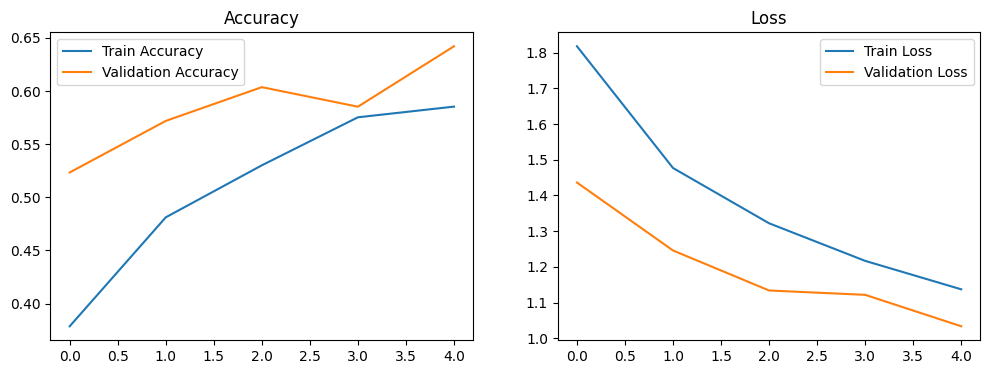

In [ ]:
# 모델 학습
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# 모델 평가
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# 학습 과정 시각화
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

plot_history(history)